In [1]:
# use the environment of py-gplate
import sys
import gplately
import numpy as np
import gplately.pygplates as pygplates
from gplately import ptt
import glob, os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib import gridspec
import cartopy.crs as ccrs
from plate_model_manager import PlateModelManager
import json

# directory to the aspect Lab
ASPECT_LAB_DIR = os.environ['ASPECT_LAB_DIR']
sys.path.append(ASPECT_LAB_DIR)
RESULT_DIR = os.path.join(ASPECT_LAB_DIR, 'results')
import shilofue.GPlateLib as GPlateLib
# import utilities in subdirectiory
sys.path.append(os.path.join(ASPECT_LAB_DIR, 'utilities', "python_scripts"))
import Utilities


### workflow for subduction dataset from reconstruction
We define a workflow to query the subduction plate dataset from plate reconstruction

To read additional properties (i.e. name, start / end time, we need to load the plate reconstruction files)

To fix the age of the subducting plate, we need to make sure we pinned our poins on the subducting plate.
I defined a automatic workflow and a manual workflow.
the automatic workflow is tried first, and the manual workflow is used to fix invalid values.
The results is then recorded in a csv file, to be loaded later.

In [2]:
# enter the directory of the plate reconstruction files and check
dir_re = os.path.join(ASPECT_LAB_DIR, "dtemp/gplate_export_test0/Muller_etal_2019_PlateBoundaries_no_topologies")
assert(os.path.isdir(dir_re))

In [3]:
# initiate the class
GClass = GPlateLib.GPLATE_CLASS()
GParseReconstruction = GPlateLib.PARSERECONSTRUCTION()

downloading https://repo.gplates.org/webdav/pmm/muller2019/Rotations.zip
The local file(s) is/are still good. Will not download again at this moment.
downloading https://repo.gplates.org/webdav/pmm/muller2019/Topologies.zip
The local file(s) is/are still good. Will not download again at this moment.
downloading https://repo.gplates.org/webdav/pmm/muller2019/StaticPolygons.zip
The local file(s) is/are still good. Will not download again at this moment.
downloading https://repo.gplates.org/webdav/pmm/muller2019/Coastlines.zip
The local file(s) is/are still good. Will not download again at this moment.
downloading https://repo.gplates.org/webdav/pmm/muller2019/ContinentalPolygons.zip
The local file(s) is/are still good. Will not download again at this moment.
downloading https://repo.gplates.org/webdav/pmm/muller2019/COBs.zip
The local file(s) is/are still good. Will not download again at this moment.


In [4]:
# assign a reconstruction time
reconstruction_time=0 # time of reconstruction, must be integar

GClass.SetReconstructionTime(reconstruction_time)
GClass.Reconstruct()
infile = os.path.join(dir_re, "reconstructed_%.2dMa.xy" % reconstruction_time)
GParseReconstruction.ReadFile(infile)

downloading https://www.earthbyte.org/webdav/ftp/Data_Collections/Muller_etal_2019_Tectonics/Muller_etal_2019_Agegrids/Muller_etal_2019_Tectonics_v2.0_netCDF/Muller_etal_2019_Tectonics_v2.0_AgeGrid-0.nc
The local file(s) is/are still good. Will not download again at this moment.


In [5]:
# resample by a give arc length edge and resample section
arc_length_edge = 5.0  # by degree
arc_length_resample_section = 10.0
use_recorded_file = True; # use this option to start from a recorded file
# use_recorded_file = False; # use this option to start over

# resample the subduction zones
recorded_file = os.path.join(ASPECT_LAB_DIR, "files", "ThDSubduction", "gplate_json_files", "subduction_resampled_t_%.2e_edge_%.2f_section_%.2f.csv" \
                         % (reconstruction_time, arc_length_edge, arc_length_resample_section))
if use_recorded_file:
    assert(os.path.isfile(recorded_file))
    subduction_data_resampled = pd.read_csv(recorded_file) 
else:
    subduction_data_resampled = GClass.ResampleAllSubduction(arc_length_edge, arc_length_resample_section)
    subduction_data_resampled['age'] = [np.nan for i in range(len(subduction_data_resampled))]
    subduction_data_resampled['lon_fix'] = [np.nan for i in range(len(subduction_data_resampled))]
    subduction_data_resampled['lat_fix'] = [np.nan for i in range(len(subduction_data_resampled))]
    subduction_data_resampled['fix_age_polarity'] = [np.nan for i in range(len(subduction_data_resampled))]
    # todo_ages
    subduction_data_resampled['marker'] = [np.nan for i in range(len(subduction_data_resampled))]
    subduction_data_resampled['marker_fill'] = ['none' for i in range(len(subduction_data_resampled))]
    subduction_data_resampled['color'] = [np.nan for i in range(len(subduction_data_resampled))]

# fix the ages
GClass.FixTrenchAge(subduction_data_resampled)
print(subduction_data_resampled.age)

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object o

0      51.214699
1      44.222672
2      50.272339
3      19.002985
4      22.832230
5      27.722893
6            NaN
7     112.351852
8      28.741730
9     151.225800
10    135.400848
11     36.180370
12     74.763367
13     48.675430
14     25.441601
15    152.013885
16     94.963470
17     36.564899
18      4.716359
19     23.028942
20     78.649193
21      6.767121
Name: age, dtype: float64


In [6]:
# get the invalid indexes
invalid_indexes = []
for i in range(len(subduction_data_resampled['age'])):
    if np.isnan(subduction_data_resampled['age'][i]):
        invalid_indexes.append(i)

print("len(ages): ")
print(len(subduction_data_resampled['age']))
print("ages: ")
print(subduction_data_resampled['age'])
print("invalid_indexes: ")
print(invalid_indexes)

# generate an output file for fixing the ages
fix_invalid_ds = [-1 for i in range(len(invalid_indexes))]
fix_invalid_thetas = [-1 for i in range(len(invalid_indexes))]

# export the file to a temp file
temp_file = os.path.join(ASPECT_LAB_DIR, "dtemp", "gplate_export_test0", "subduction_resampled_t_%.2e_edge_%.2f_section_%.2f.csv" \
                         % (reconstruction_time, arc_length_edge, arc_length_resample_section))

subduction_data_resampled.to_csv(temp_file)
print("Data saved to %s" % temp_file)

len(ages): 
22
ages: 
0      51.214699
1      44.222672
2      50.272339
3      19.002985
4      22.832230
5      27.722893
6            NaN
7     112.351852
8      28.741730
9     151.225800
10    135.400848
11     36.180370
12     74.763367
13     48.675430
14     25.441601
15    152.013885
16     94.963470
17     36.564899
18      4.716359
19     23.028942
20     78.649193
21      6.767121
Name: age, dtype: float64
invalid_indexes: 
[6]
Data saved to /home/lochy/ASPECT_PROJECT/aspectLib/dtemp/gplate_export_test0/subduction_resampled_t_0.00e+00_edge_5.00_section_10.00.csv


Save figure: /home/lochy/ASPECT_PROJECT/aspectLib/results/gplate_subduction_zones/subduction_resampled_t_0.00e+00_edge_5.00_section_10.00.pdf
Save figure: /home/lochy/ASPECT_PROJECT/aspectLib/results/gplate_subduction_zones/subduction_resampled_t_0.00e+00_edge_5.00_section_10.00.png


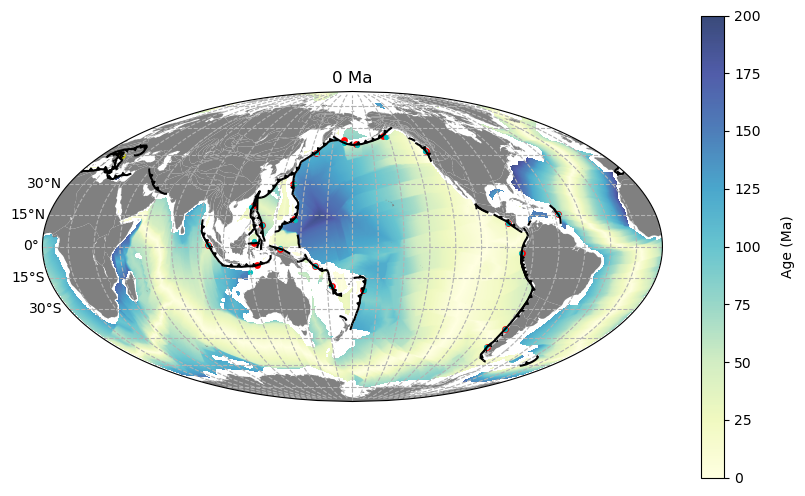

In [7]:
# basic plots
# plot the reconstructed zone
fig = plt.figure(figsize=(10,6), dpi=100)
ax = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 180))
gl=ax.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))
gl.left_labels = True
plt.title(f'{reconstruction_time} Ma')
# you may change the extent to global to see the sample points in a world map.
ax.set_global()
# ax.set_extent([-80,0,-70,0])
# plot the coastline
GClass.PlotCoastlines(ax)
# plot the seafloor age
im_age = GClass.PlotSeaFloorAges(ax)
# plot all subduction zones and subduction teeth
# im_sub = GPlateLib.plot_one_subduction_data(ax, GClass.GetSubductionData())
GClass.gplot.plot_trenches(ax, color='k')
GClass.gplot.plot_subduction_teeth(ax, color='k')

# plot all the fixed ages
mask = (~subduction_data_resampled['age'].isna())
ax.scatter(subduction_data_resampled[mask].lon, subduction_data_resampled[mask].lat, marker=".", s=60, c='r', transform=ccrs.PlateCarree())
ax.scatter(subduction_data_resampled[~mask].lon, subduction_data_resampled[~mask].lat, marker=".", s=60, c='y', transform=ccrs.PlateCarree())
ax.scatter(subduction_data_resampled[mask].lon_fix, subduction_data_resampled[mask].lat_fix, marker=".", s=30, c='c', transform=ccrs.PlateCarree())

# set plot options
cbar_age = plt.colorbar(im_age) # colorbar for ages
cbar_age.ax.get_yaxis().labelpad = 15
cbar_age.ax.set_ylabel("Age (Ma)", rotation=90)

# write outputs
fileout = os.path.join(RESULT_DIR, "gplate_subduction_zones", "subduction_resampled_t_%.2e_edge_%.2f_section_%.2f.pdf" \
                         % (reconstruction_time, arc_length_edge, arc_length_resample_section))
fileout1 = os.path.join(RESULT_DIR, "gplate_subduction_zones", "subduction_resampled_t_%.2e_edge_%.2f_section_%.2f.png" \
                         % (reconstruction_time, arc_length_edge, arc_length_resample_section))
if not (os.path.isdir(os.path.dirname(fileout))):
    os.mkdir(os.path.dirname(fileout))
fig.savefig(fileout)
fig.savefig(fileout1)
print("Save figure: %s" % fileout)
print("Save figure: %s" % fileout1)

### Fix the invalid values

First, open the recorded file under

    files/ThDSubduction/gplate_json_files/

If no file is recorded yet, copy the file under this folder first

    dtemp/gplate_export_test0/

Then map out the invalid ages from the outputs from the previous section.

Use the polarity entry to twik the result of ages. There are two things to do:

    1. switch between 0.0 and 1.0 to query the point to different side of the trench
    2. use a 2.0 value and manually assign the point to use (lon_fix, lat_fix)

The next section is for interact with existing results and improve on it.

theta: 235.9224, d: 6.0000e+05
lon: 479.5194, lat: -11.8519
new_age:  [150.965]


Text(0, 0.5, 'Convergence Velocity Magnitude (in cm/yr)')

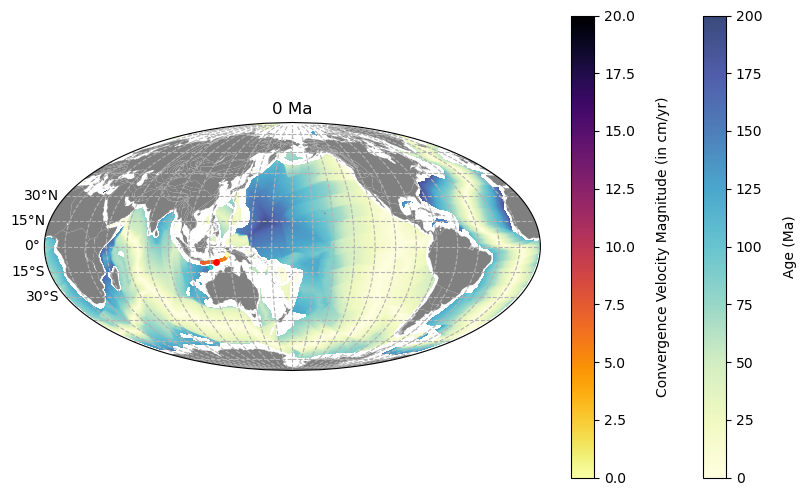

In [8]:
# fix the invalid age manually
i = 9
theta = 525.9224 - 360.0 + 70.0 # None: use the azimuth angle instead
d = 600e3 # m

# get the original pint
subduction_data_resampled_local = pd.DataFrame([subduction_data_resampled.iloc[i]])
# get the trench id
trench_id = subduction_data_resampled.iloc[i].trench_pid
if theta is None:
    theta = subduction_data_resampled.iloc[i].trench_azimuth_angle + 180.0

# migrate the point and interpolate age
subduction_data_resampled_local.lon, subduction_data_resampled_local.lat = \
    Utilities.map_point_by_distance(subduction_data_resampled.iloc[i].lon, subduction_data_resampled.iloc[i].lat, theta, d)
new_age = GClass.InterpolateAgeGrid(subduction_data_resampled_local)
print("theta: %.4f, d: %.4e" % (theta, d))
print("lon: %.4f, lat: %.4f" % (subduction_data_resampled_local.lon, subduction_data_resampled_local.lat))
print("new_age: ", new_age)

# get the data of this subduction zone
one_subduction_data = GClass.GetOneSubductionByTrenchId(trench_id)

# basic plots
# plot the reconstructed zone
fig = plt.figure(figsize=(10,6), dpi=100)
ax = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 180))
gl=ax.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))
gl.left_labels = True
plt.title(f'{reconstruction_time} Ma')
# you may change the extent to global to see the sample points in a world map.
ax.set_global()
# ax.set_extent([-80,0,-70,0])
# plot the coastline
GClass.PlotCoastlines(ax)
# plot the seafloor age
im_age = GClass.PlotSeaFloorAges(ax)

# plot the subduction zone
im_sub = GPlateLib.plot_one_subduction_data(ax, one_subduction_data)
# plot the original point
im_sub_point =ax.scatter(subduction_data_resampled.iloc[i].lon, subduction_data_resampled.iloc[i].lat, marker=".", s=60, c='r', transform=ccrs.PlateCarree())
# plot the migrated point
im_sub_point =ax.scatter(subduction_data_resampled_local.lon, subduction_data_resampled_local.lat, marker=".", s=30, c='c', transform=ccrs.PlateCarree())

# set plot options
cbar_age = plt.colorbar(im_age) # colorbar for ages
cbar_age.ax.get_yaxis().labelpad = 15
cbar_age.ax.set_ylabel("Age (Ma)", rotation=90)
cbar = plt.colorbar(im_sub) # colorbar for trenches
cbar.ax.get_yaxis().labelpad = 15
# cbar.ax.set_ylabel('Trench Velocity Magnitude (in cm/yr)', rotation=90) # choose between these two labels to use for trenches
cbar.ax.set_ylabel('Convergence Velocity Magnitude (in cm/yr)', rotation=90)

### Plot all trenches

We plot the convergence / trench retreat rate of trenches below.
The plot is also combined with a sea floor age

### Get the age of the subducting plate at these query points

Issue: We get a lot of nan value in ages
1. check the position of the sample points
2. plot the raster of oceanic plate ages

Here we generate a variation of the previous plot, by differentiating valid age values and invalid age values.

[201. 511. 602. 608. 645. 653. 801. 802. 901. 903. 909. 911.]
Total plotted points: 21
figure saved: /home/lochy/ASPECT_PROJECT/aspectLib/results/gplate_subduction_zones/subduction_distribution_t_0.00e+00_edge_5.00_section_10.00.pdf
csv file saved: /home/lochy/ASPECT_PROJECT/aspectLib/results/gplate_subduction_zones/subduction_distribution_t_0.00e+00_edge_5.00_section_10.00.csv


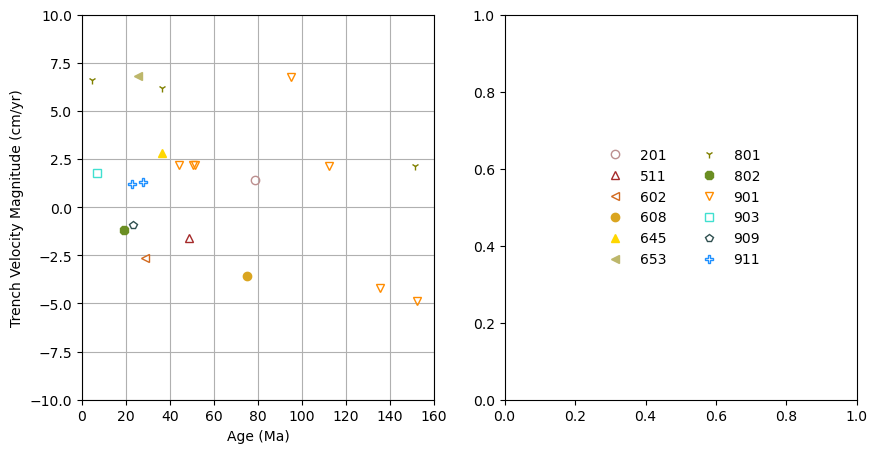

In [9]:
# todo_ages
plot_options = {
    "201": ['o', "rosybrown", 'none'],
    "511": ['^', "brown", 'none'],
    "602": ['<', "chocolate", 'none'],
    "608": ['o', "goldenrod", 'full'],
    "645": ['^', "gold", 'full'],
    "653": ['<', "darkkhaki", 'full'],
    "801": ['1', "olive", 'full'],
    "802": ['8', "olivedrab", 'full'],
    "901": ['v', "darkorange", 'none'],
    "903": ['s', "turquoise", 'none'],
    "909": ['p', "darkslategray", 'none'],
    "911": ['P', "dodgerblue", 'none']
}

# todo_ages
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
total_points_plotted = 0 # record the number of plotted points

# sort out all the valid data
mask = (~subduction_data_resampled["age"].isna())
total_points_plotted += len(subduction_data_resampled[mask])
subduction_data_resampled_valid = subduction_data_resampled[mask]

unique_subducting_ids = subduction_data_resampled_valid.subducting_pid.unique()
labels = []
patches = []
unique_subducting_ids.sort()
print(unique_subducting_ids)

unique_subducting_names = []
for i in range(len(unique_subducting_ids)):
    subducting_id = unique_subducting_ids[i]
    unique_subducting_names.append(GParseReconstruction.LookupNameByPid(int(subducting_id)))

for i in range(len(unique_subducting_ids)):
    subducting_id = unique_subducting_ids[i]
    if str(int(subducting_id)) not in plot_options:
        # skip if the current id is not included
        continue
    mask = (subduction_data_resampled.subducting_pid == subducting_id)
    _marker = plot_options[str(int(subducting_id))][0]
    _color = mcolors.to_rgb(plot_options[str(int(subducting_id))][1])
    _label = "%d" % (subducting_id)
    _patch = ax1.plot(subduction_data_resampled.age[mask], subduction_data_resampled_valid.trench_velocity[mask],\
             '.', marker=_marker, fillstyle=plot_options[str(int(subducting_id))][2],\
                color=_color, label=_label)[0]
    patches.append(_patch)
    # labels.append(_label)
    # patches.append(mpatches.Patch(color=_color, marker=marker))
i += 1

ax1.grid()
ax2.legend(handles=patches, bbox_to_anchor=(0.5, 0.5), loc='center', ncol=2, numpoints=1, frameon=False)

print("Total plotted points: %d" % total_points_plotted)

# configuration
ax1.set_xlim([0, 160.0])
ax1.set_ylim([-10.0, 10.0])
ax1.set_xlabel("Age (Ma)")
ax1.set_ylabel("Trench Velocity Magnitude (cm/yr)")

fileout = os.path.join(RESULT_DIR, "gplate_subduction_zones", "subduction_distribution_t_%.2e_edge_%.2f_section_%.2f.pdf"\
     % (reconstruction_time, arc_length_edge, arc_length_resample_section))
fig.savefig(fileout)
print("figure saved: %s" % fileout)

# dump the id - name to a csv file to lookup
csv_out = os.path.join(RESULT_DIR, "gplate_subduction_zones", "subduction_distribution_t_%.2e_edge_%.2f_section_%.2f.csv"\
     % (reconstruction_time, arc_length_edge, arc_length_resample_section))
unique_data = {
    "pid": unique_subducting_ids,
    'name': unique_subducting_names
}
df_unique_data = pd.DataFrame(unique_data)
df_unique_data.to_csv(csv_out)
print("csv file saved: %s" % csv_out)